# Program

In [1]:
import os
import time
import sys
import json
import copy
import math
import numpy as np
import ipyvolume as ipv
import pathlib
import pandas as pd
import random
from datetime import datetime
import matplotlib.pyplot as plt

import tyssue
import tyssue.dynamics
import tyssue.dynamics.factory
import tyssue.stores
import tyssue.config.geometry
import tyssue.io
import tyssue.draw
import tyssue.draw.plt_draw
from tyssue import SheetGeometry as geom
from tyssue.dynamics import effectors, units
from tyssue.dynamics.factory import model_factory
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.utils import to_nd

import scipy
import scipy.optimize
from scipy.spatial.distance import squareform, pdist, cdist

Verbose = False

%matplotlib inline

SIM_DIR = pathlib.Path('.')

#from polarity.solver import find_energy_min

In [2]:
from tyssue import config, Sheet, PlanarGeometry
from tyssue.dynamics import effectors, model_factory
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import plot_forces
from tyssue.utils import data_at_opposite
from tyssue.solvers import QSSolver


## Init 

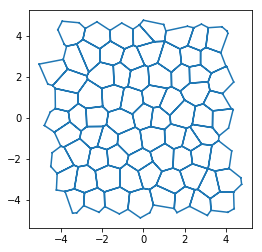

In [33]:
sheet = Sheet.planar_sheet_2d('jam', 15, 15, 1, 1, noise=0.2)
PlanarGeometry.update_all(sheet)
solver = QSSolver(with_t1=True, with_collisions=False)


sheet.remove(sheet.cut_out([[0, 10], [0, 10]]))
sheet.sanitize()
PlanarGeometry.scale(sheet, sheet.face_df.area.mean()**-0.5, ['x', 'y'])
PlanarGeometry.center(sheet)
PlanarGeometry.update_all(sheet)
sheet.reset_index()
sheet.reset_topo()
fig, ax = sheet_view(sheet, mode='quick')

#### Keep a copy of the initial sheet
 so that we can try several times the bloc below with no need to run each time the whole thing from the start
 
 The copy is also used to make compared graphics in the end

In [34]:
InitialSheet = copy.deepcopy(sheet)

In [35]:
class LineTensionPolarity(effectors.AbstractEffector):

    dimensions = units.line_tension
    magnitude = "line_tension_polarity"
    label = "Line tension with polarity"
    element = "edge"
    specs = {"edge": {"is_active", "line_tension", "concentration"}}

    spatial_ref = "mean_length", units.length

    @staticmethod
    def energy(eptm):
        return eptm.edge_df.eval(
            "line_tension" "* is_active" "* length" "* concentration"
        )  # accounts for half edges

    @staticmethod
    def gradient(eptm):
        grad_srce = -eptm.edge_df[eptm.ucoords] * to_nd(
            eptm.edge_df.eval("line_tension * is_active/2 * concentration"),
            len(eptm.coords)
        )
        grad_srce.columns = ["g" + u for u in eptm.coords]
        grad_trgt = -grad_srce
        return grad_srce, grad_trgt
    
class Compression(effectors.AbstractEffector):
    
    @staticmethod
    def energy(sheet):
        return sheet.vert_df.eval('0.5 * compression * x**2')
        
    @staticmethod
    def gradient(sheet):
        grad = sheet.vert_df[sheet.coords].copy()
        grad.columns = ['gx', 'gy']
        grad['gy'] = 0
        grad['gx'] = sheet.vert_df.eval("compression * x")
        return grad, None
        

Reseting column is_alive of the face dataset with new specs
Reseting column is_active of the vert dataset with new specs


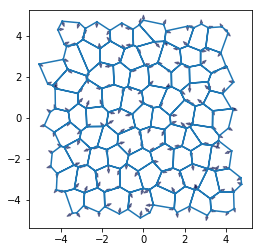

In [36]:

model = model_factory([#effectors.LineTension,
                        LineTensionPolarity,
                       #effectors.FaceContractility,
                       Compression,
                       effectors.FaceAreaElasticity])

polarity_specs = {
    "edge": {
        "concentration": 0.1,
        "o_concentration": 0.1,
        "b_concentration": 0.,
        "recrutment": 10,
        "auto_catalytic": 5.,
        "susceptibility": 1e-3,
        "desorption": 0.01,
        "temperature":25.,
        "mechano_sensitivity": 20.,
        "friction" : 5.
    },
    "face": {
        "protein_number": 1.,
        "concentration": 1.
    }
}

dynamics_specs = {
    "edge": {
        "is_active": 1,
        "line_tension": 0.02,
        "ux": 0.0,
        "uy": 0.0,
        "uz": 0.0,
    },
    "face": {
        "is_alive": 1,
        "area_elasticity": 1.,
        "prefered_area": 1.,
        "contractility": 0.12
    },
    "vert": {
        "compression": 1.e-3,
        "extension": 1.,
        "is_active": 1,
        "viscosity": 1e-2,
    },
    "settings": {
        "tension0": 0.01
    }
}


sheet.update_specs(polarity_specs)
sheet.update_specs(dynamics_specs, reset=True)
sheet.get_opposite()

fig, ax = plot_forces(sheet, PlanarGeometry, model, list('xy'), scaling=1)
InitialSheet = copy.deepcopy(sheet)

In [37]:
# Condensation de la position des edges
sheet = copy.deepcopy(InitialSheet)
def _list_index(edges):
    return list(edges.index)
    
ordered_edges = sheet.edge_df.groupby('face').apply(_list_index)
sheet.edge_df = pd.DataFrame([sheet.edge_df.loc[e] for l in ordered_edges for e in l])
sheet.reset_index()


In [38]:
# creation d'une matrice identite de taille Ne x Ne
V_ij = np.eye(sheet.Ne, sheet.Ne)
ordered_edges = sheet.edge_df.groupby('face').apply(_list_index)

for o_e in ordered_edges:
    i,j = np.meshgrid(o_e,o_e)
    for ii, jj in zip(i.ravel(), j.ravel()):
        if ii != jj : 
            V_ij[ii,jj] = -sheet.edge_df.loc[jj, 'length']/\
            sheet.face_df.loc[sheet.edge_df.loc[ii, 'face'], 'perimeter']
    

In [72]:
# creation d'une matrice identite de taille Ne x Ne
U_ij = np.zeros((sheet.Ne, sheet.Ne))
ordered_edges = sheet.edge_df.groupby('face').apply(_list_index)

for o_e in ordered_edges:
    i,j = np.meshgrid(o_e,o_e)
    for ii, jj in zip(i.ravel(), j.ravel()):
        if ii == jj :
            #epsilon0*Ci
            U_ij[ii,ii] += sheet.edge_df.loc[ii, 'auto_catalytic'] 
            #-J/li
            U_ij[ii,ii] += -sheet.edge_df.loc[ii, 'desorption'] / sheet.edge_df.loc[ii,'length']
            
        elif ii != jj : 
            #-epsilon0*li/p
            U_ij[ii,jj] += - (sheet.edge_df.loc[ii, 'auto_catalytic'] 
                            * (sheet.edge_df.loc[ii, 'length']
                            / sheet.face_df.loc[sheet.edge_df.loc[ii, 'face'], 'perimeter']))
                
                    
            # Parcours des edges opposes
            if sheet.edge_df.loc[jj, 'opposite'] !=-1:
                opposite_pos = sheet.edge_df.loc[jj, 'opposite']
                
                #epsilon2
                U_ij[ii, opposite_pos] += (
                        - sheet.edge_df.loc[jj, 'recrutment']
                        *(sheet.edge_df.loc[opposite_pos, 'length']
                        / sheet.face_df.loc[sheet.edge_df.loc[jj, 'face'], 'perimeter']))
                        
                # J*Cj/li
                U_ij[ii, opposite_pos] += (sheet.edge_df.loc[opposite_pos, 'desorption']
                                            / sheet.edge_df.loc[opposite_pos, 'length'])

                 
                
                
        #Opposite edge
        #epsilon2*Cj
        U_ij[ii, sheet.edge_df.loc[ii, 'opposite']] += sheet.edge_df.loc[ii, 'recrutment']
        
        

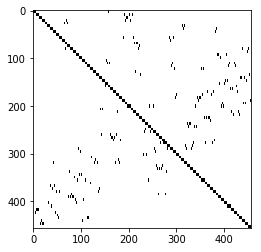

In [67]:
plt.imshow(U_ij!=0, cmap='Greys')

In [71]:
U = U_ij * sheet.edge_df.concentration.values
Te = 10
V = - Te * V_ij * np.log(sheet.edge_df.concentration.values)


73.80586533796297
1749.9646706754738


In [65]:
(U - V).sum()

-1676.1588053375112

In [80]:
# creation d'une matrice identite de taille Ne x Ne
U_ij = np.zeros((sheet.Ne, sheet.Ne))
ordered_edges = sheet.edge_df.groupby('face').apply(_list_index)

pts = sheet.edge_df.index.values

#epsilon0*Ci
U_ij[pts, pts] += sheet.edge_df['auto_catalytic'] 
#-J/li
U_ij[pts, pts] += -sheet.edge_df['desorption'] / sheet.edge_df['length']
    
#Opposite edge
#epsilon2*Cj
U_ij[pts, sheet.edge_df['opposite']] += sheet.edge_df['recrutment']


for o_e in ordered_edges:
    i,j = np.meshgrid(o_e,o_e)
    for ii, jj in zip(i.ravel(), j.ravel()): 
        #-epsilon0*li*Ci/p
        U_ij[ii,jj] += - (sheet.edge_df.loc[ii, 'auto_catalytic'] 
                        * (sheet.edge_df.loc[ii, 'length']
                        / sheet.face_df.loc[sheet.edge_df.loc[ii, 'face'], 'perimeter']))


        # Parcours des edges opposes
        opposite_pos = sheet.edge_df.loc[jj, 'opposite']
        if opposite_pos !=-1:

            #epsilon2*lj*Cj/perimeter
            U_ij[ii, opposite_pos] += (
                    - sheet.edge_df.loc[jj, 'recrutment']
                    *(sheet.edge_df.loc[opposite_pos, 'length']
                    / sheet.face_df.loc[sheet.edge_df.loc[jj, 'face'], 'perimeter']))

            # J*Cj/li
            U_ij[ii, opposite_pos] += (sheet.edge_df.loc[opposite_pos, 'desorption']
                                        / sheet.edge_df.loc[opposite_pos, 'length'])



In [7]:
class ChemGeom(PlanarGeometry):
    
    @classmethod
    def update_all(cls, sheet):
        super().update_all(sheet)
        cls.update_tension(sheet)
        cls.update_concentrations(sheet)
        
    @staticmethod
    def update_tension(sheet):
        sheet.edge_df['line_tension'] = sheet.edge_df.eval(
            'susceptibility * concentration') + sheet.settings["tension0"]

    @staticmethod
    def update_concentrations(sheet):
        sheet.face_df['concentration'] = (
            sheet.face_df['protein_number'] 
            - sheet.sum_face(sheet.edge_df.eval('length * concentration'))
        ) / sheet.face_df["area"]
        sheet.edge_df['o_concentration'] = data_at_opposite(
            sheet, sheet.edge_df["concentration"], free_value=0)
        sheet.edge_df['b_concentration'] = sheet.upcast_face('concentration')
        

            
class Extension(effectors.AbstractEffector):
    
    @staticmethod
    def energy(sheet):
        return sheet.vert_df.eval('-0.5 * extension * y**2')
        
    @staticmethod
    def gradient(sheet):
        grad = sheet.vert_df[sheet.coords].copy()
        grad.columns = ['gx', 'gy']
        grad['gx'] = 0
        grad['gy'] = sheet.vert_df.eval("-extension*y")
        return grad, None
        

def set_pos(pos, sheet):
    vert_pos = pos[:sheet.Nv * sheet.dim].reshape((sheet.Nv, -1))
    sheet.vert_df[sheet.coords] = vert_pos
    concentrations = pos[sheet.Nv * sheet.dim:]

    sheet.edge_df["concentration"] = concentrations
    ChemGeom.update_all(sheet)
    

def ode_rhs(sheet):
    
    dot_positions = - (model.compute_gradient(sheet).values 
                       / sheet.vert_df['viscosity'].values[:, None]).ravel()
    dot_concentrations = sheet.edge_df.eval(
        "(auto_catalytic * concentration +"
        "recrutment * o_concentration -"
        #"desorption/length * (concentration-concentration_neighbor) -"
        "desorption/length * (concentration-concentration*4/3) -"
        "temperature * log(concentration))/friction").values
        
    """ "- desorption * concentration + ("
    "auto_catalytic * concentration"
    "+ mechano_sensitivity * line_tension"
    "+ recrutment * o_concentration) * b_concentration").values"""
    
    return np.concatenate((dot_positions, dot_concentrations))


def get_ode(sheet):
    
    def ode(t, pos):
        set_pos(pos, sheet)
        return ode_rhs(sheet)

    return ode

from scipy.integrate import solve_ivp

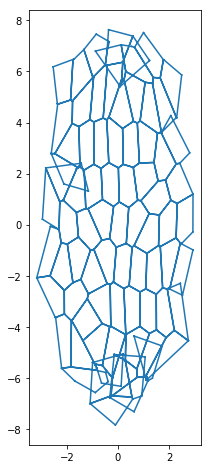

In [8]:
# Resolution mecanique
res = solver.find_energy_min(sheet, PlanarGeometry, model)


fig, ax = sheet_view(sheet, mode='quick',)
fig.set_size_inches((8, 8))

In [9]:
# Resolution chimique
pos_0 = np.concatenate((sheet.vert_df[sheet.coords].values.ravel(),
                        sheet.edge_df['concentration'].ravel()))
ode = get_ode(sheet)


res = solve_ivp(ode, (0, 1.), pos_0)

In [90]:
fig, ax = sheet_view(
    sheet, mode='2D',
    edge={
        "color": sheet.edge_df['line_tension'],
        'head_width':0,
        'width': (0.1 + 3*sheet.edge_df['line_tension']/sheet.edge_df['line_tension'].max())},
    vert={"visible": False})
fig.set_size_inches((8, 8))

KeyError: 'line_tension'

In [89]:
fig, ax = sheet_view(
    sheet, mode='2D',
    edge={
        "color": sheet.edge_df['concentration'],
        'head_width':0,
        'width': (0.1 + 3*sheet.edge_df['concentration']/sheet.edge_df['concentration'].max())},
    vert={"visible": False})
fig.set_size_inches((8, 8))

KeyError: 'concentration'

In [12]:
EllipsoidBModel = model_factory(
    [
    LineTensionPolarity,
    effectors.FaceAreaElasticity
    ], effectors.FaceAreaElasticity)

model = EllipsoidBModel

In [13]:

solver_kw = {'minimize': {'method': 'SLSQP',
                          'options': {'ftol': 1e-6,
                                     'maxiter': 20}}}
                                      #'gtol': 1e-8}}}
res = Solver.find_energy_min(sheet, geom, model, **solver_kw)

KeyError: 'height_axis'

In [ ]:
sheet2 = InitialSheet.extract_bounding_box(
    y_boundary=[-100,100], 
    x_boundary = [-200,200], 
    z_boundary=[-400,400])
fig, ax = tyssue.draw.sheet_view(sheet2, 
            edge={'color_range': [0,0.4],'color':sheet2.edge_df.C_a, 'width':1}, 
            vert={'visible':False}, coords = ['x','y'])
ax.set_title('Initial')

In [ ]:
InitialSheet = copy.deepcopy(sheet)